In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

Read each fitting results file and print the fitting criteria and mean parameters

In [2]:
DATA_DIR = "../../data/fitting_results"
FIGURE_DIR = "../../figures"
all_model_dfs = {}
for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
    df = pd.read_csv(f"{DATA_DIR}/fitting_results_{agent_type}.csv")
    print(f"agent type: {agent_type}, n={len(df)}")
    all_model_dfs[agent_type] = df
    print(f"{agent_type} llh: {df['ll'].sum()}")
    print(f"{agent_type} AIC: {df['AIC'].sum()}")
    print(f"{agent_type} llh mean: {df['ll'].mean()}")
    print(f"{agent_type} AIC mean: {df['AIC'].mean()}")
    if agent_type == "lqr":
        print(f"mean exp param: {df['exp_param'].mean()}")
        print(f"mean vm param: {df['vm_param'].mean()}")

agent type: lqr, n=111
lqr llh: -12814.156823000001
lqr AIC: 26072.313646000002
lqr llh mean: -115.44285426126127
lqr AIC mean: 234.88570852252255
mean exp param: 0.009394379738242795
mean vm param: 2.018399246203047
agent type: sparse_lqr, n=111
sparse_lqr llh: -8635.006088999999
sparse_lqr AIC: 17936.012177999997
sparse_lqr llh mean: -77.79284764864863
sparse_lqr AIC mean: 161.58569529729726
agent type: sparse_max_discrete, n=111
sparse_max_discrete llh: -8217.55531
sparse_max_discrete AIC: 17323.110619999996
sparse_max_discrete llh mean: -74.03202981981981
sparse_max_discrete AIC mean: 156.0640596396396
agent type: sparse_max_continuous, n=111
sparse_max_continuous llh: -8404.733314
sparse_max_continuous AIC: 17697.466628000002
sparse_max_continuous llh mean: -75.71831814414413
sparse_max_continuous AIC mean: 159.4366362882883
agent type: null_model_1, n=111
null_model_1 llh: -9611.043459600001
null_model_1 AIC: 20110.086919200003
null_model_1 llh mean: -86.58597711351352
null_model

In [3]:
pp_nrs = pd.read_csv('../../data/experimental_data/experiment_ppids.csv')['id']

Get the number of participants best fit by each model, as well as the strength of evidence for the best model over the second-best model for each participant

In [4]:
evidence_strengths = []
evidence_vs_lqr = []
models_by_best_fitting_pps = defaultdict(int)
participant_to_best_model = {}
for pp_id in pp_nrs:
    participant_fits = {}
    for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
        df = all_model_dfs[agent_type]

        if len(df[df['pp_id'] == pp_id]['AIC']) != 1:
            print("len:", len(df[df['pp_id'] == pp_id]['AIC']))
            break
        participant_fits[agent_type] = float(df[df['pp_id'] == pp_id]['AIC'])

    if len(df[df['pp_id'] == pp_id]) != 1:
        continue
    
    sorted_fits = sorted(participant_fits.values())
    evidence_strengths.append(sorted_fits[1] - sorted_fits[0])
    best_agent = min(participant_fits, key=participant_fits.get)
    
    evidence_vs_lqr.append(participant_fits['lqr'] - participant_fits[best_agent])
    
    models_by_best_fitting_pps[best_agent] += 1
    participant_to_best_model[pp_id] = best_agent

print(models_by_best_fitting_pps)

defaultdict(<class 'int'>, {'null_model_2': 12, 'hill_climbing': 33, 'sparse_max_discrete': 34, 'sparse_lqr': 17, 'sparse_max_continuous': 11, 'null_model_1': 3, 'lqr': 1})


Create csv files for Bayesian model selection (done using SPM8)

In [5]:
df_aics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert AICs to log model evidence format
    df_aics[df_type] = all_model_dfs[df_type]['AIC'].apply(lambda x: -x/2)
df_aics.to_csv(f"{DATA_DIR}/aic_lme.csv")

n_params = {"null_model_2": 2, "null_model_1": 4, "lqr": 2, "sparse_lqr": 3, "hill_climbing": 3, "sparse_max_continuous": 4, "sparse_max_discrete": 4}
df_bics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert BICs to log model evidence format
    df_bics[df_type] = all_model_dfs[df_type]["ll"].apply(lambda x: - (n_params[df_type] * np.log(10) - 2 * x) / 2)
df_bics.to_csv(f"{DATA_DIR}/bic_lme.csv")

In [6]:
# make a csv file with the best-fitting model and parameters for each participant
df_bestfit = pd.DataFrame()
for pp_id in pp_nrs:
    best_model_type = participant_to_best_model[pp_id]
    df = all_model_dfs[best_model_type]
    row = df[df['pp_id'] == pp_id]
    df_bestfit = df_bestfit.append(row, ignore_index=True)
df_bestfit.to_csv(f"{DATA_DIR}/best_fitting_models.csv")

Get the mean best-fitting parameter for each model type

In [7]:
for model_type in df_bestfit['agent_type'].drop_duplicates():
    df_model = df_bestfit[df_bestfit['agent_type'] == model_type]
    print(f"MODEL TYPE: {model_type}")
    print(f"exp param: {df_model['exp_param'].mean()}")
    print(f"vm param: {df_model['vm_param'].mean()}")
    print(f"step size: {df_model['step_size'].mean()}")
    print(f"attention cost: {df_model['attention_cost'].mean()}")
    print(f"n: {np.round(df_model['n']).mean()}")
    print(f"b: {df_model['b'].mean()}")

MODEL TYPE: null_model_2
exp param: 0.02684512480888621
vm param: 5.529558395537163
step size: nan
attention cost: nan
n: nan
b: nan
MODEL TYPE: hill_climbing
exp param: 0.0753174585848244
vm param: 5.847075951865594
step size: 0.3771653962982217
attention cost: 0.0
n: nan
b: nan
MODEL TYPE: sparse_max_discrete
exp param: 0.10355139496121514
vm param: 4.1444084534421135
step size: 0.7136881195696764
attention cost: 14.814530150384574
n: nan
b: nan
MODEL TYPE: sparse_lqr
exp param: 0.04794128802357909
vm param: 5.233783169701627
step size: nan
attention cost: 112.05888667865689
n: nan
b: nan
MODEL TYPE: sparse_max_continuous
exp param: 0.03232379085424222
vm param: 5.804558151644079
step size: 0.14309335323630937
attention cost: 13.980779170633788
n: nan
b: nan
MODEL TYPE: null_model_1
exp param: 0.317516674287246
vm param: 7.408719892568108
step size: nan
attention cost: nan
n: 1.3333333333333333
b: 1.1286195138786983
MODEL TYPE: lqr
exp param: 0.0247858565556271
vm param: 4.2181787227

In [8]:
# print the mean evidence strength (difference in AIC between top two models for a given participant)
print(np.mean(evidence_strengths))
print(np.std(evidence_strengths))

5.645716118918919
5.403066070777357


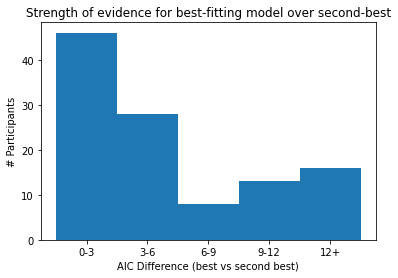

In [9]:
bins=(0,3,6,9,12,15)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_strengths, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(1.5,15,3))
ax.set_xticklabels(("0-3", "3-6", "6-9", "9-12", "12+"))
ax.set_xlabel("AIC Difference (best vs second best)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over second-best")
fig.savefig("../../figures/evidence_strength_best_second.pdf", bbox_inches="tight")

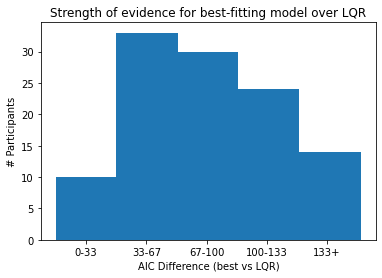

In [10]:
bins=(0,33,67,100,133,167)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_vs_lqr, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(16.5,167,33))
ax.set_xticklabels(("0-33", "33-67", "67-100", "100-133", "133+"))
ax.set_xlabel("AIC Difference (best vs LQR)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over LQR")
fig.savefig("../../figures/evidence_strength_best_lqr.pdf", bbox_inches="tight")

In [11]:
np.mean(evidence_vs_lqr)

84.66746012972973

In [12]:
len([x for x in evidence_vs_lqr if x <= -16])

0

In [13]:
len([x for x in evidence_strengths if x <= -4])

0

In [14]:
best_fit_pps = {}
for agent_type in ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']:
    best_fit_pps[agent_type] = [pp_id for pp_id in pp_nrs if participant_to_best_model[pp_id] == agent_type]

In [15]:
non_null_agent_types = ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']

## Qualitative Analysis

In [16]:
raw_pp_data_path = '../../data/experimental_data/experiment_actions.csv'
df_pps = pd.read_csv(raw_pp_data_path)

In [17]:
df_last = df_pps.loc[df_pps.groupby("pp_id")['Unnamed: 0'].idxmax()]

Get scores by which model explains each pp best

In [18]:
scores_by_best_model = defaultdict(list)
for index, row in df_last.iterrows():
    scores_by_best_model[participant_to_best_model[row['pp_id']]].append(np.sqrt(row['total_cost']))

In [19]:
for m in scores_by_best_model:
    print(f"{m} median: {np.median(scores_by_best_model[m])}")
    print(f"{m} mean: {np.mean(scores_by_best_model[m])}")
    print(f"m sem: {stats.sem(scores_by_best_model[m])}")

sparse_lqr median: 115.66256957200979
sparse_lqr mean: 165.44785083029697
m sem: 31.271008064803464
sparse_max_continuous median: 161.59439965543362
sparse_max_continuous mean: 237.920787118682
m sem: 92.64738477519306
sparse_max_discrete median: 111.88814032925194
sparse_max_discrete mean: 107.04867830186448
m sem: 13.367267405409097
hill_climbing median: 113.60154048251282
hill_climbing mean: 113.28701290974269
m sem: 9.58241757635166
null_model_1 median: 143.8314291106085
null_model_1 mean: 256.45746189789014
m sem: 172.44905079021487
null_model_2 median: 311.6366506775473
null_model_2 mean: 8427.774548694691
m sem: 7565.884973195463
lqr median: 26.191410805834806
lqr mean: 26.191410805834806
m sem: nan


C:\Users\bprys\miniconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\bprys\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
np.median(scores_by_best_model['sparse_lqr'])

115.66256957200979

In [21]:
np.median(scores_by_best_model['hill_climbing'])

113.60154048251282

In [22]:
def bootstrap_ci(data, n=1000000):
    all_medians = []
    for i in range(n):
        bs_data = np.random.choice(data, len(data), replace=True)
        med = np.median(bs_data)
        all_medians.append(med)
    all_medians = np.array(all_medians)
    lower_bound = np.percentile(all_medians, 2.5)
    upper_bound = np.percentile(all_medians, 97.5)
    
    return lower_bound, upper_bound

In [23]:
for model_type in ("sparse_lqr", "hill_climbing"):
    scores = scores_by_best_model[model_type]
    lower_bound, upper_bound = bootstrap_ci(scores)
    print(f"{model_type}: {np.median(scores)}, [{lower_bound}, {upper_bound}]")

sparse_lqr: 115.66256957200979, [68.86254424576542, 261.79812833555553]
hill_climbing: 113.60154048251282, [96.429404229208, 120.33004612315247]


In [24]:
stats.kruskal(scores_by_best_model['sparse_lqr'], scores_by_best_model['hill_climbing'])

KruskalResult(statistic=0.7936458005661962, pvalue=0.3729999871930284)

Get descriptive stats like number of variables manipulated.

In [25]:
print(len(scores_by_best_model['sparse_lqr']) + len(scores_by_best_model['hill_climbing']))

50


Compute the number of variables manipulated and input norm standard deviation for humans.

In [26]:
n_variables_manipulated = []
n_all_zero = 0
norms = []
for index, row in df_pps.iterrows():
    exogenous = literal_eval(row['exogenous_input'])
    n_manipulated = len([x for x in exogenous if x != 0])
    if exogenous == [0., 0., 0., 0.]:
        n_all_zero += 1
    n_variables_manipulated.append(n_manipulated)
    norms.append(sum([x**2 for x in exogenous]))
    
mean_manip = np.mean(n_variables_manipulated)
ci_manip = 1.96 *stats.sem(n_variables_manipulated)
print(f"mean number of variables manipulated: {mean_manip}")
print(f"95% CI number of variables manipulated: {(mean_manip - ci_manip, mean_manip + ci_manip)}")
print(f"median number of variables manipulated: {np.median(n_variables_manipulated)}")
print(f"iqr number of variables manipulated: {stats.iqr(n_variables_manipulated)}")
print(f"number of all zero inputs: {n_all_zero}")
print(f"norm med: {np.median(norms)}")
print(f"norm iqr: {stats.iqr(norms)}")
print(f"norm std: {np.std(norms)}")

mean number of variables manipulated: 2.0631199278629397
95% CI number of variables manipulated: (1.99701877926644, 2.1292210764594395)
median number of variables manipulated: 2.0
iqr number of variables manipulated: 2.0
number of all zero inputs: 56
norm med: 134.0
norm iqr: 759.0
norm std: 3482646.332299877


In [27]:
all_norm_meds = []
all_norm_stds = []
for pp in df_pps['pp_id'].drop_duplicates():
    norms = []
    for index, row in df_pps[df_pps['pp_id'] == pp].iterrows():
        exogenous = literal_eval(row['exogenous_input']) 
        norm = np.sqrt(sum([x**2 for x in exogenous]))
        norms.append(norm)
    # print(f"median norm: {np.median(norms)}")
    # print(f"std norm: {np.std(norms)}")
    all_norm_stds.append(np.std(norms))
    all_norm_meds.append(np.median(norms))

In [28]:
np.median(all_norm_meds)

11.269078289549748

In [29]:
np.median(all_norm_stds)

14.681139904908841